In [1]:
import pandas as pd
import numpy as np

In [2]:
dataset_location = "/Users/Xutao/Documents/CR4CR/dataset/"
df = pd.read_excel(dataset_location + "Market 00abc_240310.xlsx")

In [3]:
# Since there are some null responses will a score of 0, we want to replace them with empty strings
df.fillna("", inplace=True)

# select only the three responses columns and the score column
response_columns = ["Market.00a_OE", "Market.00bc_OE", "Market.00bc_OE follow up"]
score_column = ["Score"]
df = df[["Respondent Id", "Administration"] + response_columns + score_column]

In [4]:
import re
def preprocess_text(text):
    # Lowercase the text
    # text = text.lower()

    text = re.sub(r'\n', ' ', text)
    #text = re.sub(r'^\w+\s*$', '',text)

    text = re.sub(r'[^a-zA-Z0-9\+\-\s]', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    return text

def preprocess_text1(text):
    # Lowercase the text
    text = text.lower()

    # text = re.sub(r'\n', ' ', text)
    # Remove special characters
    #text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    # Strip leading and trailing whitespace
    text = text.strip()

    return text

# Preprocess the text in the response columns
for column in response_columns:
    df[column] = df[column].astype(str).apply(preprocess_text1)

In [12]:
from transformers import BertTokenizer, BertModel, DistilBertPreTrainedModel, RobertaForSequenceClassification
#from transformers.modeling_distilbert import DistilBertModel, DistilBertPreTrainedModel
from torch import nn
from sklearn.preprocessing import OneHotEncoder


class MultimodalRoberta(torch.nn.Module):
    def __init__(self, num_labels=5): 
        super(MultimodalRoberta, self).__init__()
        self.num_labels = num_labels
        self.roberta1 = RobertaModel.from_pretrained('distilroberta-base')
        self.roberta2 = RobertaModel.from_pretrained('distilroberta-base')
        self.roberta3 = RobertaModel.from_pretrained('distilroberta-base')
        self.classifier = nn.Linear(self.roberta1.config.hidden_size + self.roberta2.config.hidden_size + self.roberta3.config.hidden_size, num_labels)

    def forward(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b, input_ids_c, attention_mask_c):
        output_a = self.roberta1(input_ids=input_ids_a, attention_mask=attention_mask_a)
        output_b = self.roberta2(input_ids=input_ids_b, attention_mask=attention_mask_b)
        output_c = self.roberta3(input_ids=input_ids_c, attention_mask=attention_mask_c)

        concatenated_output = torch.cat((output_a.pooler_output, output_b.pooler_output, output_c.pooler_output), 1)

        return self.classifier(concatenated_output)


class MultimodalRobertaDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.columns = ["Market.00a_OE", "Market.00bc_OE", "Market.00bc_OE follow up"]
        self.labels = self.dataframe['Score'].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        # Selecting sentence1 and sentence2 at the specified index in the data frame
        row = self.dataframe.iloc[index]
        response_a = row['Market.00a_OE']
        response_b = row['Market.00bc_OE']
        response_c = row['Market.00bc_OE follow up']
        score = row['Score']

        # Tokenize the pair of sentences to get token ids, attention masks and token type ids
        encoding_a = self.tokenizer.encode_plus(response_a, add_special_tokens=True, max_length=self.max_length, padding='max_length', return_attention_mask=True, truncation=True)
        encoding_b = self.tokenizer.encode_plus(response_b, add_special_tokens=True, max_length=self.max_length, padding='max_length', return_attention_mask=True, truncation=True)
        encoding_c = self.tokenizer.encode_plus(response_c, add_special_tokens=True, max_length=self.max_length, padding='max_length', return_attention_mask=True, truncation=True)

        return {
            'input_ids_a': torch.tensor(encoding_a['input_ids'], dtype=torch.long),
            'attention_mask_a': torch.tensor(encoding_a['attention_mask'], dtype=torch.long),
            'input_ids_b': torch.tensor(encoding_b['input_ids'], dtype=torch.long),
            'attention_mask_b': torch.tensor(encoding_b['attention_mask'], dtype=torch.long),
            'input_ids_c': torch.tensor(encoding_c['input_ids'], dtype=torch.long),
            'attention_mask_c': torch.tensor(encoding_c['attention_mask'], dtype=torch.long),
            'score': torch.tensor(score, dtype=torch.float)
        }

c:\Users\Xutao\miniconda3\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [13]:
def split_and_load_dataset(df, batch_size=8, val=False):

    tokenizer = RobertaTokenizer.from_pretrained('roberta-base', output_attentions=False)
    if val == False:
        train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Score'], random_state=42)
        
        train_dataset = MultimodalRobertaDataset(train_df, tokenizer)
        val_dataset = MultimodalRobertaDataset(val_df, tokenizer)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        return train_loader, val_loader, None
    else:
        train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Score'], random_state=42)
        val_df, test_df = train_test_split(val_df, test_size=0.5, stratify=val_df['Score'], random_state=42)

        train_dataset = MultimodalRobertaDataset(train_df, tokenizer)
        val_dataset = MultimodalRobertaDataset(val_df, tokenizer)
        test_dataset = MultimodalRobertaDataset(test_df, tokenizer)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        return train_loader, val_loader, test_loader
    


In [23]:
train_loader, val_loader, test_loader = split_and_load_dataset(df, batch_size=1, val=True)

In [24]:
def train(loss_fn, lr, EPOCH):
    model = MultimodalRoberta()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    model.train()
    for epoch in range(EPOCH):
        total_loss = 0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(
                batch['input_ids_a'].to(device), batch['attention_mask_a'].to(device),
                batch['input_ids_b'].to(device), batch['attention_mask_b'].to(device),
                batch['input_ids_c'].to(device), batch['attention_mask_c'].to(device)
            )
            loss = loss_fn(outputs, batch['score'].to(device).long())
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        print("Average training loss: {0:.2f}".format(avg_train_loss))

    return model



In [9]:
-+
MultimodalRobertaModel = train(nn.CrossEntropyLoss(), 1e-5, 5)

NameError: name 'train' is not defined

In [10]:
def train_and_validate(loss_fn, lr, EPOCH):
    model = MultimodalRoberta()  # Ensure MultimodalRoberta is defined or imported correctly.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss, val_loss = [], []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(EPOCH):
        total_train_loss = 0
        model.train()
        for batch in train_loader:  # Ensure train_loader is defined or passed as an argument.
            optimizer.zero_grad()
            outputs = model(
                batch['input_ids_a'].to(device), batch['attention_mask_a'].to(device),
                batch['input_ids_b'].to(device), batch['attention_mask_b'].to(device),
                batch['input_ids_c'].to(device), batch['attention_mask_c'].to(device)
            )
            loss = loss_fn(outputs, batch['score'].to(device).long())
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_loss.append(avg_train_loss)
        print(f"Epoch {epoch+1}, Average training loss: {avg_train_loss:.2f}")

        total_val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in val_loader:  # Ensure val_loader is defined or passed as an argument.
                outputs = model(
                    batch['input_ids_a'].to(device), batch['attention_mask_a'].to(device),
                    batch['input_ids_b'].to(device), batch['attention_mask_b'].to(device),
                    batch['input_ids_c'].to(device), batch['attention_mask_c'].to(device)
                )
                loss = loss_fn(outputs, batch['score'].to(device).long())
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)
        print(f"Epoch {epoch+1}, Average validation loss: {avg_val_loss:.2f}")

    return model, train_loss, val_loss

In [25]:

def train_and_validate(loss_fn, lr, EPOCH):
    model = MultimodalRoberta()  # Ensure MultimodalRoberta is defined or imported correctly.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss, val_loss = [], []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(EPOCH):
        total_train_loss = 0
        model.train()
        for batch in train_loader:  # Ensure train_loader is defined or passed as an argument.
            optimizer.zero_grad()
            outputs = model(
                batch['input_ids_a'].to(device), batch['attention_mask_a'].to(device),
                batch['input_ids_b'].to(device), batch['attention_mask_b'].to(device),
                batch['input_ids_c'].to(device), batch['attention_mask_c'].to(device)
            )
            loss = loss_fn(outputs, batch['score'].to(device).long())
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_loss.append(avg_train_loss)
        print(f"Epoch {epoch+1}, Average training loss: {avg_train_loss:.2f}")

        total_val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in val_loader:  # Ensure val_loader is defined or passed as an argument.
                outputs = model(
                    batch['input_ids_a'].to(device), batch['attention_mask_a'].to(device),
                    batch['input_ids_b'].to(device), batch['attention_mask_b'].to(device),
                    batch['input_ids_c'].to(device), batch['attention_mask_c'].to(device)
                )
                loss = loss_fn(outputs, batch['score'].to(device).long())
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)
        print(f"Epoch {epoch+1}, Average validation loss: {avg_val_loss:.2f}")

    return model, train_loss, val_loss

model, training_losses, validation_losses = train_and_validate(nn.CrossEntropyLoss(), 1e-5, 20)


Epoch 1, Average training loss: 1.09
Epoch 1, Average validation loss: 1.00
Epoch 2, Average training loss: 0.64
Epoch 2, Average validation loss: 0.98
Epoch 3, Average training loss: 0.37
Epoch 3, Average validation loss: 0.93
Epoch 4, Average training loss: 0.22
Epoch 4, Average validation loss: 1.19
Epoch 5, Average training loss: 0.10
Epoch 5, Average validation loss: 1.38
Epoch 6, Average training loss: 0.11
Epoch 6, Average validation loss: 1.48
Epoch 7, Average training loss: 0.06
Epoch 7, Average validation loss: 1.48
Epoch 8, Average training loss: 0.03
Epoch 8, Average validation loss: 1.65


KeyboardInterrupt: 

In [17]:
validation_losses

[1.0647824630141258,
 0.8689702749252319,
 0.7878904864192009,
 0.9251010157167912,
 0.9772705249488354,
 1.2196252159774303,
 1.3015515860170126,
 1.2138779107481241,
 1.3455352652817965,
 1.5801946800202131,
 1.5069765839725733,
 1.577058034017682,
 1.5463356487452984,
 1.5494423490017653,
 1.6147966906428337,
 1.6361410189419985,
 1.6318280566483736,
 1.6609520930796862,
 1.6894803382456303,
 1.6999119725078344]

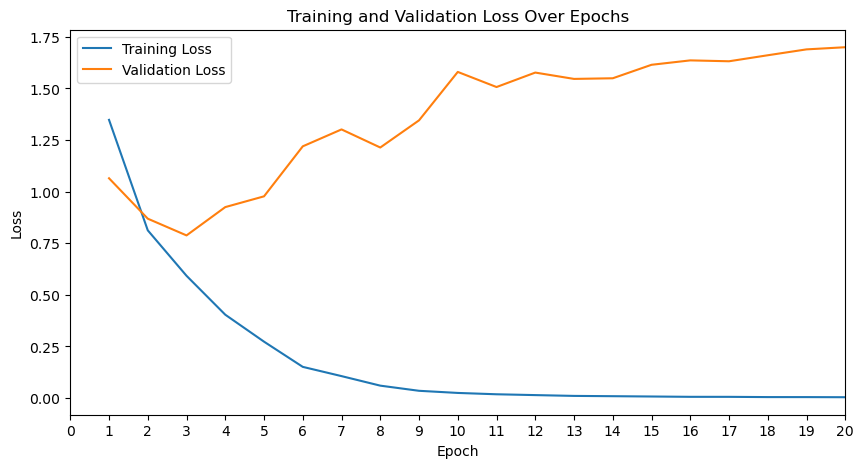

In [20]:
## plot the training and validation losses with respect to the number of epochs to check for overfitting'
import matplotlib.pyplot as plt
epochs = np.arange(1, 21)

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs (Batch Size = 8)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xlim(1, 20)
plt.xticks(np.arange(0, 21, 1))
plt.show()



In [13]:
torch.cuda.empty_cache()

In [14]:
#4. Cross-Validation with Varying Data Sizes
#Description: Perform k-fold cross-validation multiple times with increasing amounts of training data.
#How to Use: Plot the average cross-validation accuracy against the size of the training data. If the performance steadily improves with more data and has not plateaued, it indicates that additional data could continue to enhance performance.

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cross_validation(model, loss_fn, lr, EPOCH, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []

    for train_idx, val_idx in kfold.split(df):
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base', output_attentions=False)
        train_dataset = MultimodalRobertaDataset(train_df, tokenizer)
        val_dataset = MultimodalRobertaDataset(val_df, tokenizer)

        train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

        model = train(loss_fn, lr, EPOCH)

        device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
        model.to(device)

        model.eval()
        with torch.no_grad():
            predictions = []
            true_labels = []
            for batch in val_loader:
                outputs = model(
                    batch['input_ids_a'].to(device), batch['attention_mask_a'].to(device),
                    batch['input_ids_b'].to(device), batch['attention_mask_b'].to(device),
                    batch['input_ids_c'].to(device), batch['attention_mask_c'].to(device)
                )
                predictions.append(outputs.argmax(dim=1).cpu().numpy())
                true_labels.append(batch['score'].cpu().numpy())

            predictions = np.concatenate(predictions)
            true_labels = np.concatenate(true_labels)

            accuracy = accuracy_score(true_labels, predictions)
            accuracies.append(accuracy)

    return accuracies

In [15]:
accuracy_score = cross_validation(MultimodalRoberta(), nn.CrossEntropyLoss(), 1e-5, 2, 10)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['robert

Average training loss: 1.09
Average training loss: 0.75


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.12
Average training loss: 0.78


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.10
Average training loss: 0.70


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.14
Average training loss: 0.78


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.12
Average training loss: 0.71


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.06
Average training loss: 0.67


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.10
Average training loss: 0.73


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.07
Average training loss: 0.73


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.09
Average training loss: 0.75


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.13
Average training loss: 0.71


In [16]:
accuracy_score

[0.7,
 0.7,
 0.8,
 0.8333333333333334,
 0.7833333333333333,
 0.7,
 0.8666666666666667,
 0.75,
 0.711864406779661,
 0.7966101694915254]

In [8]:
def evaluate(model, val_loader):
    model.eval()
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            # Forward pass
            outputs = model(
                batch['input_ids_a'].to(device), batch['attention_mask_a'].to(device),
                batch['input_ids_b'].to(device), batch['attention_mask_b'].to(device),
                batch['input_ids_c'].to(device), batch['attention_mask_c'].to(device)
            )
            #all_predictions.extend(outputs.cpu().numpy())
            #all_labels.extend(batch['score'].numpy())

            _, outputs = torch.max(outputs, 1)
            all_predictions.extend(outputs.cpu().numpy())
            all_labels.extend(batch['score'].numpy())

    all_predictions = np.array(all_predictions).flatten()
    correct_predictions = sum(all_predictions == np.array(all_labels))
    total_predictions = len(all_predictions)
    test_accuracy = correct_predictions / total_predictions

    print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

    return test_accuracy, all_predictions


In [ ]:
test_accuracy, all_predictions = evaluate(MultimodalRobertaModel, test_loader)

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, loss_fn, lr, EPOCH, k=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, df, df['Score'], cv=k, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 5))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Accuracy')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation Accuracy')
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [9]:
train_sizes = np.linspace(0.1, 1.0, 4)
train_sizes_int = []

train_scores = []
test_scores = []

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Score'], random_state=42)


for size in train_sizes:
    train_size = int(size * len(train_df))
    test_size = int(size * len(val_df))
    train_sizes_int.append(train_size)

    train_df_subset = train_df.iloc[:train_size]
    val_df_subset = val_df.iloc[:test_size]

    tokenizer = RobertaTokenizer.from_pretrained('roberta-base', output_attentions=False)
    train_dataset = MultimodalRobertaDataset(train_df_subset, tokenizer)
    val_dataset = MultimodalRobertaDataset(val_df_subset, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = train(nn.CrossEntropyLoss(), 1e-5, 2)


    train_accuracy, _ = evaluate(model, train_loader)
    test_accuracy, _ = evaluate(model, val_loader)

    train_scores.append(train_accuracy)
    test_scores.append(test_accuracy)

    del model
    torch.cuda.empty_cache()



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.38
Average training loss: 1.10
Test Accuracy: 53.19%
Test Accuracy: 41.67%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.31
Average training loss: 0.85
Test Accuracy: 82.72%
Test Accuracy: 58.33%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.17
Average training loss: 0.70
Test Accuracy: 76.65%
Test Accuracy: 53.57%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.13
Average training loss: 0.71
Test Accuracy: 81.38%
Test Accuracy: 63.33%


In [21]:

torch.cuda.empty_cache()

In [24]:
train_sizes = np.linspace(0.1, 1.0, 6)
train_sizes_int = []

train_scores2 = []
test_scores2 = []

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Score'], random_state=42)

train_df = train_df.sample(frac=1)
val_df = val_df.sample(frac=1)


for size in train_sizes:
    train_size = int(size * len(train_df))
    test_size = int(size * len(val_df))
    train_sizes_int.append(train_size)

    train_df_subset = train_df.iloc[:train_size]
    val_df_subset = val_df.iloc[:test_size]

    tokenizer = RobertaTokenizer.from_pretrained('roberta-base', output_attentions=False)
    train_dataset = MultimodalRobertaDataset(train_df_subset, tokenizer)
    val_dataset = MultimodalRobertaDataset(val_df_subset, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = train(nn.CrossEntropyLoss(), 1e-5, 2)


    train_accuracy, _ = evaluate(model, train_loader)
    test_accuracy, _ = evaluate(model, val_loader)

    train_scores2.append(train_accuracy)
    test_scores2.append(test_accuracy)

    del model
    torch.cuda.empty_cache()



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.55
Average training loss: 1.35
Test Accuracy: 61.70%
Test Accuracy: 58.33%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.43
Average training loss: 0.95
Test Accuracy: 60.90%
Test Accuracy: 51.52%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.31
Average training loss: 0.78
Test Accuracy: 85.84%
Test Accuracy: 58.18%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.26
Average training loss: 0.80
Test Accuracy: 82.30%
Test Accuracy: 68.42%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.14
Average training loss: 0.73
Test Accuracy: 82.86%
Test Accuracy: 64.29%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.13
Average training loss: 0.72
Test Accuracy: 85.36%
Test Accuracy: 66.67%


In [12]:
train_sizes = np.linspace(0.1, 1.0, 6)
train_sizes_int = []

train_scores2 = []
test_scores2 = []

semester_used = []

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Administration'], random_state=42)

semesters = np.array(['Spr 22', 'Fall 22', 'Spr 23', 'Fall 23'], dtype=object)

for semester in semesters:
    ## accumulately train on all semesters
    semester_used.append(semester)
    train_df_subset = train_df[train_df['Administration'].isin(semester_used)]
    val_df_subset = val_df[val_df['Administration'].isin(semester_used)]
    train_sizes_int.append(len(train_df_subset))

    tokenizer = RobertaTokenizer.from_pretrained('roberta-base', output_attentions=False)
    train_dataset = MultimodalRobertaDataset(train_df_subset, tokenizer)
    val_dataset = MultimodalRobertaDataset(val_df_subset, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = train(nn.CrossEntropyLoss(), 1e-5, 4)


    train_accuracy, _ = evaluate(model, train_loader)
    test_accuracy, _ = evaluate(model, val_loader)

    train_scores2.append(train_accuracy)
    test_scores2.append(test_accuracy)

    del model
    torch.cuda.empty_cache()



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.46
Average training loss: 1.18
Average training loss: 0.90
Average training loss: 0.61
Test Accuracy: 83.06%
Test Accuracy: 41.94%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.41
Average training loss: 0.96
Average training loss: 0.65
Average training loss: 0.51
Test Accuracy: 84.26%
Test Accuracy: 50.00%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.18
Average training loss: 0.76
Average training loss: 0.55
Average training loss: 0.39
Test Accuracy: 94.27%
Test Accuracy: 66.67%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.17
Average training loss: 0.78
Average training loss: 0.59
Average training loss: 0.41
Test Accuracy: 87.87%
Test Accuracy: 64.17%


In [28]:
semesters = df['Administration'].unique()
# RANK THE SEMESTERS from early to late
semesters = np.sort(semesters)
semesters = np.array(['Spr 22', 'Fall 22', 'Spr 23', 'Fall 23'], dtype=object)
semesters

array(['Spr 22', 'Fall 22', 'Spr 23', 'Fall 23'], dtype=object)

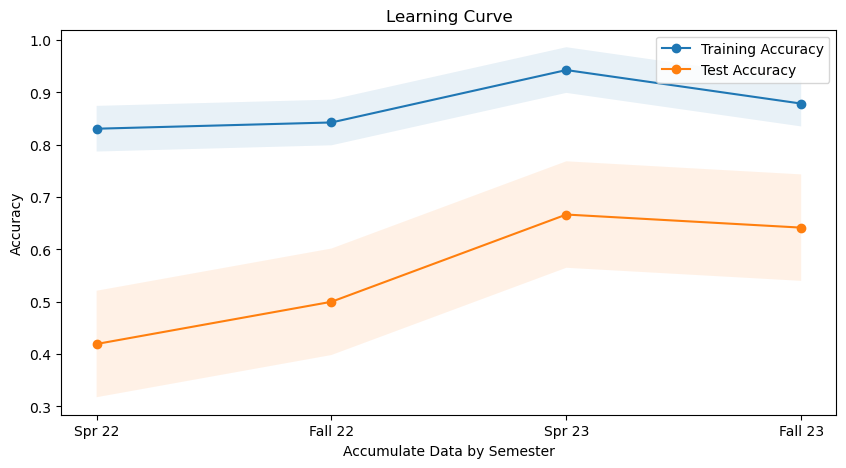

In [13]:
import matplotlib.pyplot as plt
train_scores_mean = np.mean(train_scores2)
train_scores_std = np.std(train_scores2)
test_scores_mean = np.mean(test_scores2)
test_scores_std = np.std(test_scores2)
plt.figure(figsize=(10, 5))
plt.fill_between(semesters, train_scores2 - train_scores_std, train_scores2 + train_scores_std, alpha=0.1)
plt.fill_between(semesters, test_scores2 - test_scores_std, test_scores2 + test_scores_std, alpha=0.1)
plt.plot(semesters, train_scores2, 'o-', label='Training Accuracy')
plt.plot(semesters, test_scores2, 'o-', label='Test Accuracy')
plt.title('Learning Curve')
plt.xlabel('Accumulate Data by Semester')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

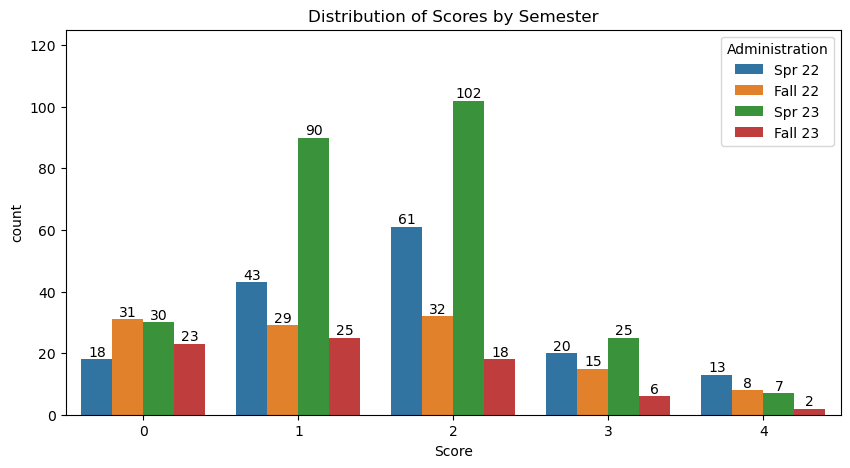

In [82]:
## draw frequency table of scores distribution for each semester put them on one horizon
import matplotlib.pyplot as plt
import seaborn as sns
# for each semester, show the distribution of scores, put them on one graph, dont stack them
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=df, x='Score', hue='Administration', ax=ax)
plt.title('Distribution of Scores by Semester')
# set ylim
plt.ylim(0, 125)
#show count of each column
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.bar_label(ax.containers[3])

plt.show()



C:\Users\Xutao\AppData\Local\Temp\ipykernel_37344\2042156476.py:15: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.countplot(data=df, x='Administration', hue='Score', ax=ax, palette=sns.color_palette())


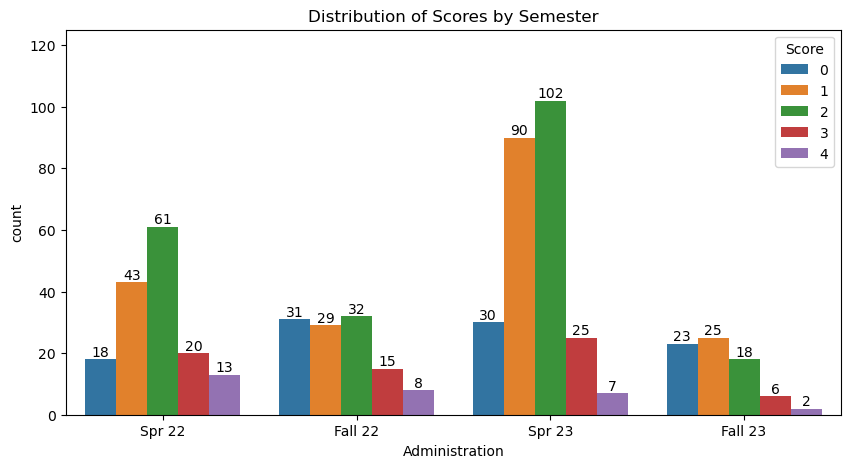

In [81]:
## for each semester, show the distribution of scores, put them on one graph, dont stack them
# i want the x-axis to be the semester

# rank df by semesters 

semesters = df['Administration'].unique()
# RANK THE SEMESTERS from early to late
semesters = np.sort(semesters)
semesters = np.array(['Spr 22', 'Fall 22', 'Spr 23', 'Fall 23'], dtype=object)

df = df.sort_values(by='Administration', key=lambda x: x.map({v: i for i, v in enumerate(semesters)}))


fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=df, x='Administration', hue='Score', ax=ax, palette=sns.color_palette())
plt.title('Distribution of Scores by Semester')
plt.ylim(0, 125)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.bar_label(ax.containers[3])
ax.bar_label(ax.containers[4])

plt.show()
